In [2]:
import json
import os
from collections.abc import Sequence

from mlflow.exceptions import RestException
from mlflow.tracking import MlflowClient


In [3]:
from typing import NamedTuple

import jax
import jax.numpy as jnp


class Metric(NamedTuple):
    steps: jax.Array
    values: jax.Array

In [4]:
def download_metrics(run_id: str, metric_keys: Sequence[str]) -> dict[str, Metric]:
    """Downloads metrics of the form "validation/token_loss_{i}" for i in range(100) from a given MLflow run.

    Parameters:
        experiment_id (str): MLflow experiment ID.
        run_id (str): MLflow run ID.
        output_path (str, optional): File path to save the metrics as JSON. If None, does not save to disk.

    Returns:
        dict: Dictionary containing the token loss metrics.
    """
    client = MlflowClient(tracking_uri="databricks")

    metrics = {}
    for key in metric_keys:
        try:
            metric_history = client.get_metric_history(run_id, key)
            metrics[key] = Metric(
                steps=jnp.array([m.step for m in metric_history]),
                values=jnp.array([m.value for m in metric_history]),
            )
        except RestException:
            print(f"Metric {key} not found")
    return metrics

In [5]:
def save_metrics(metrics: dict, output_path: str | None = None) -> None:
    """Save metrics to a JSON file."""
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        with open(output_path, "w") as f:
            json.dump(metrics, f, indent=2)
        print(f"Metrics saved to {output_path}")

In [6]:
p = 0.4
q = 0.25
r = 1 - p - q
h = 0.5

min_loss = -q * jnp.log(h)
for v in [p, q, r]:
    min_loss -= v * jnp.log(v)
min_loss /= (1 + 2 * q)

In [7]:
min_loss

Array(0.83587635, dtype=float32, weak_type=True)

## Transformer

In [75]:
run_id = "b71869abbbdc4ff39119fdbce4de2416" # "41ff4d850c174b3fa45e821be3c1e7ad"
metric_keys = [f"validation/token_loss_{i}" for i in range(100)]
metrics = download_metrics(run_id, metric_keys)
new_metrics: dict[int, Metric] = {int(k.split("_")[-1]): v for k, v in metrics.items() if v.steps.size > 0}
set(range(100)) - set(new_metrics.keys())

{99}

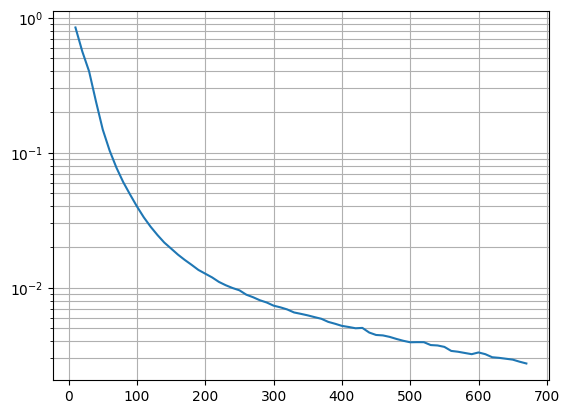

In [76]:
import matplotlib.pyplot as plt

m = new_metrics[50]
x = m.steps
y = m.values

plt.figure()
plt.semilogy(x, y / min_loss - 1)
plt.grid(True, which="both")
plt.show()


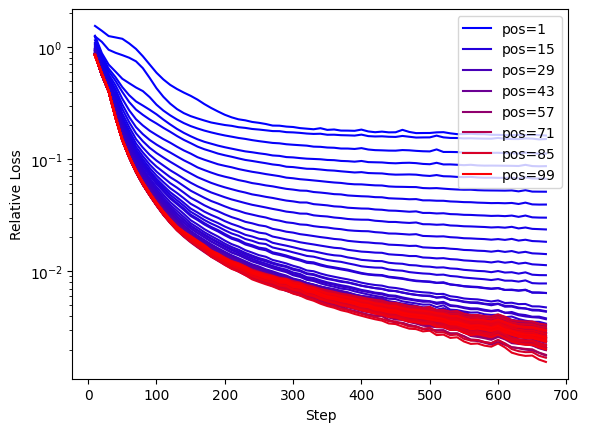

In [96]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots()

k_max = max(new_metrics.keys())

u = 99

for k in range(0, u, 1):
    v = new_metrics[k]
    color = (k / u, 0, 1 - k / u)
    if k % 14 == 0:
        plt.semilogy(v.steps, v.values / min_loss - 1, color=color, label=f"pos={k+1}")
    else:
        plt.semilogy(v.steps, v.values / min_loss - 1, color=color)

plt.xlabel("Step")
plt.ylabel("Relative Loss")
plt.legend()
plt.show()


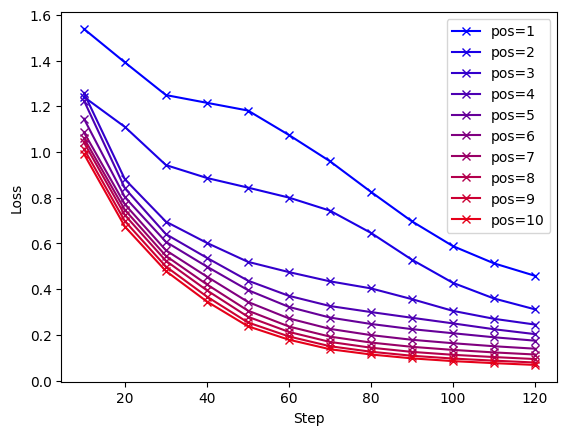

In [97]:
k_max = max(new_metrics.keys())

u = 10
p = 12

for k in range(0, u, 1):
    v = new_metrics[k]
    color = (k / u, 0, 1 - k / u)
    plt.plot(v.steps[:p], v.values[:p] / min_loss - 1, "-x", color=color, label=f"pos={k+1}")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

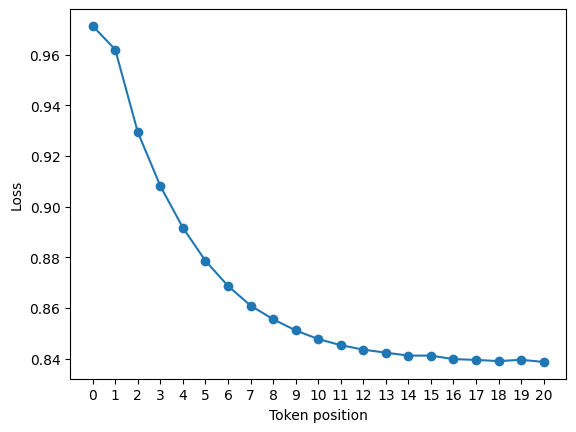

In [78]:
pos = []
loss = []
for k, v in new_metrics.items():
    if v.values.size > 0:
        pos.append(k)
        loss.append(v.values[-1])

plt.plot(jnp.array(pos)[:21], jnp.array(loss)[:21], '-o')
plt.xticks(range(21))
plt.xlabel("Token position")
plt.ylabel("Loss")
plt.show()



## RNN

In [10]:
run_id = "e4ccbc41d48c4e7dbce47c9300c5a62a"
metric_keys = [f"validation/token_loss_{i}" for i in range(100)]
metrics = download_metrics(run_id, metric_keys)
new_metrics: dict[int, Metric] = {int(k.split("_")[-1]): v for k, v in metrics.items() if v.steps.size > 0}
set(range(100)) - set(new_metrics.keys())

{99}

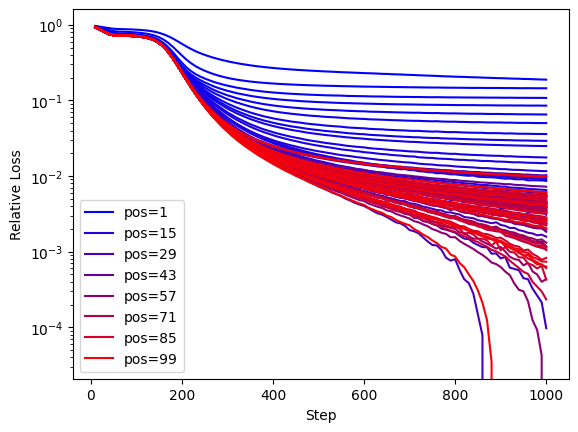

In [11]:
import matplotlib.pyplot as plt

k_max = max(new_metrics.keys())

u = 99

for k in range(0, u, 1):
    v = new_metrics[k]
    color = (k / u, 0, 1 - k / u)
    if k % 14 == 0:
        plt.semilogy(v.steps, v.values / min_loss - 1, color=color, label=f"pos={k+1}")
    else:
        plt.semilogy(v.steps, v.values / min_loss - 1, color=color)

plt.xlabel("Step")
plt.ylabel("Relative Loss")
plt.legend()
plt.show()

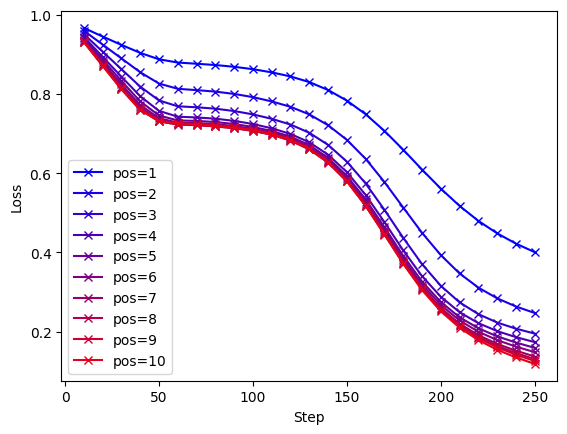

In [14]:
k_max = max(new_metrics.keys())

u = 10
p = 25

for k in range(0, u, 1):
    v = new_metrics[k]
    color = (k / u, 0, 1 - k / u)
    plt.plot(v.steps[:p], v.values[:p] / min_loss - 1, "-x", color=color, label=f"pos={k+1}")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

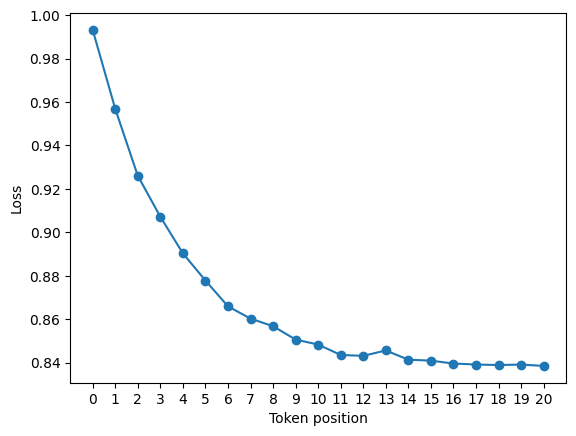

In [15]:
pos = []
loss = []
for k, v in new_metrics.items():
    if v.values.size > 0:
        pos.append(k)
        loss.append(v.values[-1])

plt.plot(jnp.array(pos)[:21], jnp.array(loss)[:21], '-o')
plt.xticks(range(21))
plt.xlabel("Token position")
plt.ylabel("Loss")
plt.show()